## Try Polars
This notebook is just for learning polars

# import libraries

In [1]:
import os
import gc
import pickle
import glob
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import time
import math
import sys

import polars as pl

import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier, Pool

import xgboost as xgb
import torch
import cupy 
import cudf
from cuml import ForestInference

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score
from sklearn.model_selection import GroupKFold
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

# Set Configurations

In [2]:
CFG = {
    "DEBUG" : False,
    "EXP_NAME" : "expCAT004",
    "n_folds" : 5,
    "train_folds" : [0,1,2,3,4],
    
}

CFG["cat_params"] = {
            'iterations': 10000,
            'learning_rate' : 0.01,
            'loss_function' : 'Logloss',
            'eval_metric' : 'AUC',
            'verbose' : 200,
            'random_seed' : 42,
            'use_best_model': True,
}


CFG["lgb_params"] = { 'boosting_type' :'dart',
                      'objective': 'binary',
                      'random_state': 21,
                      'learning_rate': 0.01,
                      'n_estimators':5000,
                      }

# CFG["xgb_params"] =  {
#                         'objective': 'binary:logistic',
#                         'eval_metric': 'auc',
#                         'learning_rate':0.01,
#                         'tree_method':'hist' if not torch.cuda.is_available() else 'gpu_hist',
#                         'seed': 42,
#                     }

if CFG["DEBUG"]:
    CFG["EXP_CATEGORY"] = "DEBUG"
    CFG["sample_num"] = 1000

CFG["INPUT_DIR"] = "/workspace/input"
CFG["OUTPUT_DIR"] = "/workspace/output"
CFG["BASE_DIR"] = os.path.join(CFG["INPUT_DIR"])
CFG["TRAIN_HELMET_CSV"] = os.path.join(CFG["BASE_DIR"], "train_baseline_helmets.csv")
CFG["TRAIN_TRACKING_CSV"] = os.path.join(CFG["BASE_DIR"], "train_player_tracking.csv")
CFG["TRAIN_VIDEO_META_CSV"] = os.path.join(CFG["BASE_DIR"], "train_video_metadata.csv")
CFG["TRAIN_LABEL_CSV"] = os.path.join(CFG["BASE_DIR"], "train_labels.csv")

CFG["NN_FEATURE_CSV_1"] = os.path.join(CFG["OUTPUT_DIR"], "expP011_PandG_bothview_swins3base224", "oof_df.csv")
CFG["NN_FEATURE_CSV_2"] = os.path.join(CFG["OUTPUT_DIR"], "expP014_PandG_nomask_swins3base224", "oof_df.csv")
CFG["NN_FEATURE_CSV_3"] = os.path.join(CFG["OUTPUT_DIR"], "expP015_PandG_nomaskzoom_swins3base224", "oof_df.csv")

CFG["TRACK_FEATURE_CSV"] = os.path.join(CFG["OUTPUT_DIR"], "expT012_Trackshift1D", "oof_df.csv")

CFG["TEST_HELMET_CSV"] = os.path.join(CFG["BASE_DIR"], "test_baseline_helmets.csv")
CFG["TEST_TRACKING_CSV"] = os.path.join(CFG["BASE_DIR"], "test_player_tracking.csv")
CFG["TEST_VIDEO_META_CSV"] = os.path.join(CFG["BASE_DIR"], "test_video_metadata.csv")
CFG["TEST_LABEL_CSV"] = os.path.join(CFG["BASE_DIR"], "sample_submission.csv")


CFG["EXP_DIR"] = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"])
if not CFG["DEBUG"]:
    os.mkdir(CFG["EXP_DIR"])

# MODEL Functions

In [3]:
def fit_lgboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_id"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())

        params = CFG["lgb_params"]
        model = LGBMClassifier(**params).fit(x_train, y_train, 
                                   eval_set=[(x_train, y_train), (x_valid, y_valid)],
                                   callbacks=[early_stopping(200), log_evaluation(100)],
                                   eval_metric=['auc'],)

        model_path = os.path.join(CFG["EXP_DIR"], f'lgb_fold{fold}.model')
        pickle.dump(model, open(model_path, 'wb'))
        importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
        display(importance.sort_values("importance", ascending=False).head(20))

        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()

    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred


In [4]:
def fit_catboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_id"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())

        params = CFG["cat_params"]
        model =  CatBoostClassifier(**params)
        model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100, early_stopping_rounds=200)
        model_path = os.path.join(CFG["EXP_DIR"], f'cat_fold{fold}.model')
        pickle.dump(model, open(model_path, 'wb'))
        importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
        display(importance.sort_values("importance", ascending=False).head(20))

        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()
    
    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred

In [5]:
def fit_xgboost(df_, feature_cols_):
    kf = GroupKFold(n_splits=CFG["n_folds"])
    X = df_[feature_cols_]
    y = df_["contact"]
    oof_pred = np.zeros(len(y), dtype=np.float32)
    generator = kf.split(X, y, df_["game_play"])
    for fold, (idx_train, idx_valid) in enumerate(generator):
        print("-")
        print(f"fold {fold}")
        # set dataset
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        display(pd.Series(y_valid).value_counts())
        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
        evals = [(xgb_train,'train'),(xgb_valid,'eval')]
        # fit
        params = CFG["xgb_params"]
        model = xgb.train(
            params,
            xgb_train,
            num_boost_round=10_000,
            early_stopping_rounds=200,
            evals=evals,
            verbose_eval=100,
        )

        model_path = os.path.join(CFG["EXP_DIR"], f'xgb_fold{fold}.model')
        model.save_model(model_path)
        _, ax = plt.subplots(figsize=(20, 16))
        xgb.plot_importance(model,
                            ax=ax,
                            importance_type='gain',
                            show_values=False)
        plt.show()

        if not torch.cuda.is_available():
            model = xgb.Booster().load_model(model_path)
        else:
            model = ForestInference.load(model_path, output_class=True, model_type='xgboost')
        
        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()
    
    oof_pred_file = os.path.join(CFG["EXP_DIR"], 'oof_pred')
    df_["pred"] = oof_pred
    np.save(oof_pred_file, oof_pred)
    auc = round(roc_auc_score(y, oof_pred), 5)
    
    def func(x_list):
        score = matthews_corrcoef(df_['contact'], df_["pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(df_['contact'], df_["pred"]>opt_threshold), 5)
    
    print(f'All Performance of the AUC:{auc}, MCC:{score}')
    return oof_pred

# Dataset Functions

In [6]:
def add_feature_cols(df_, feature_cols_, remove_col_list):
    additional_cols = list(df_.columns)
    additional_cols = [col for col in additional_cols if not col in remove_col_list]
    feature_cols_.extend(additional_cols)
    return feature_cols_

## Merge Functions

In [7]:
def target_merge_tracking(target_df_, tracking_df_, feature_cols_, SHIFT_COLS_):
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("step").cast(str),
                                                     pl.col("nfl_player_id_1"),
                                                    ], sep='_').alias('game_step_player_1'))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("step").cast(str),
                                                     pl.col("nfl_player_id_2"),
                                                    ], sep='_').alias('game_step_player_2'))
    # line man positions
    lineman_pos = ["T", "G", "C", "DE", "DT", "NG"]
    tracking_df_ = tracking_df_.with_column((pl.col("position").is_in(lineman_pos)).cast(int).alias('is_lineman'))
    
    
    # Norm cols
    norm_cols = ["x_position", "y_position", "direction", "orientation"]
    Norm_value_list = [120., 60., 360., 360.]
    for col, norm_val in zip(norm_cols, Norm_value_list):
        tracking_df_ = tracking_df_.with_column((pl.col(col)/norm_val).alias(col))
    
    # use columns
    track_cols = ["game_play", "nfl_player_id", "step", 
                   "x_position", "y_position", "datetime",
                   "speed","distance","direction","orientation",
                   "acceleration","sa", "team", "jersey_number",
                   "is_lineman",
                 ]
    track_cols.extend(SHIFT_COLS_)
    tracking_df_ = tracking_df_.select(track_cols)
    tracking_df_ = tracking_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                         pl.col("step").cast(str),
                                                         pl.col("nfl_player_id"),
                                                        ], sep='_').alias('game_step_player'))

    tracking_df_ = tracking_df_.drop(["game_play", "step", "nfl_player_id", "datetime"])

    # merge tracking to target
    for player_id in [1,2]:
        tracking_player = tracking_df_.select([pl.all().suffix(f"_{player_id}")])
        target_df_ = target_df_.join(tracking_player, on=[f"game_step_player_{player_id}"], how="left")
        # add features col
        feature_cols_ = add_feature_cols(tracking_player, feature_cols_,
                                        [f"game_step_player_{player_id}", f"frame_{player_id}", f"datetime_{player_id}"])
    # drop col
    target_df_ = target_df_.drop(["game_step_player_1", "game_step_player_2"])
    print(len(target_df_.columns))
    print("original length", len(target_df_))
    return target_df_, feature_cols_

In [8]:
def target_merge_helmet(target_df_, helmet_df_, feature_cols_):
    print("original length", len(target_df_))
    # set merge-key (game_frame_player_1,2) to merge helmet_df
    target_df_ = target_df_.with_column(((pl.col("step").cast(int)/10*59.94+5*59.94).cast(int)+1).alias("frame"))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id_1"),
                                                    ], sep='_').alias('game_frame_player_1'))
    target_df_ = target_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id_2"),
                                                    ], sep='_').alias('game_frame_player_2'))
    # set merge key
    helmet_df_ = helmet_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                     pl.col("frame").cast(str),
                                                     pl.col("nfl_player_id"),
                                                    ], sep='_').alias('game_frame_player'))

    # merge target df & helmet_df
    player_views = [[1, "Endzone"],[2, "Endzone"], [1, "Sideline"],[2, "Sideline"]]
    for player_id, view in player_views:
        helmet_view = helmet_df_.filter(pl.col("view")==view)
        helmet_view = helmet_view[["game_frame_player", "left", "width", "top", "height"]]
        helmet_view = helmet_view.select(pl.all().suffix(f"_{player_id}"))
        helmet_view = helmet_view.select([pl.col(helmet_view.columns[0]), pl.col(helmet_view.columns[1:]).prefix(f"{view[0]}_")])
        target_df_ = target_df_.join(helmet_view, on=f"game_frame_player_{player_id}", how="left")  
        # add features col
        feature_cols_ = add_feature_cols(helmet_view, feature_cols_, [f"game_frame_player_{player_id}"])

    print(len(target_df_.columns))
    print("original length", len(target_df_))
    return target_df_, feature_cols_

## Create feature function

In [9]:
def get_tracking_shift(tracking_df_, shift_cols=["x_position","y_position"], shift_nums=range(-6,6,1)):
    # get shift key
    tracking_df_ = tracking_df_.with_column(pl.concat_str([pl.col("game_play"),
                                                         pl.col("nfl_player_id"),
                                                        ], sep='_').alias('shift_key'))
    # get shift features
    shift_col_list = []
    for num in shift_nums:
        tracking_df_ = tracking_df_.with_columns(
                            pl.col(shift_cols).shift(periods=num).over("shift_key").suffix(f"_shift{num}"))
    for col in shift_cols:
        colname = [f"{col}_shift{idx}" for idx in shift_nums]
        shift_col_list.extend(colname)
                    
    return tracking_df_, shift_col_list

In [10]:
def create_trackmerged_ftr(target_df_, feature_cols_,
                           diff_cols = ['x_position', 'y_position', 'speed', 'distance',
                                        'direction', 'orientation', 'acceleration', 'sa']):    
#     target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col("x_position_1")-pl.col("x_position_2")) \
#                                               + np.square(pl.col("y_position_1")-pl.col("y_position_2"))) \
#                                       ).alias("players_dis"))
    target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col("x_position_1")*120. - pl.col("x_position_2")*120.) \
                                              + np.square(pl.col("y_position_1")*60. - pl.col("y_position_2")*60.)) \
                                      ).alias("players_dis"))
    target_df_ = target_df_.with_column(pl.col("players_dis").fill_null(0))
    
    # players distance sum(in shift range time : default(-6~6 frames not step))
    players_distance_sum = 0
    for idx in range(-6,6,1):
        players_distance_sum += np.sqrt((target_df_[f"x_position_shift{idx}_1"] - target_df_[f"x_position_shift{idx}_2"])**2 \
                                       + (target_df_[f"y_position_shift{idx}_1"] - target_df_[f"y_position_shift{idx}_2"])**2)
    target_df_ = target_df_.with_column(pl.Series("players_distance_sum", players_distance_sum))
    target_df_ = target_df_.with_column(pl.col("players_distance_sum").fill_null(0))
    feature_cols_.append("players_distance_sum")

    # players each axis distance sum(in shift range time : default(-6~6 frames not step))
    for axis in ["x", "y"]:
        axis_distance_1 = 0
        axis_distance_2 = 0
        for idx in range(-6, 5, 1):
            axis_distance_1 += abs(target_df_[f"{axis}_position_shift{idx}_1"] - target_df_[f"{axis}_position_shift{idx+1}_1"])
            axis_distance_2 += abs(target_df_[f"{axis}_position_shift{idx}_2"] - target_df_[f"{axis}_position_shift{idx+1}_2"])
        target_df_ = target_df_.with_column(pl.Series(f"{axis}_move_distance_1", axis_distance_1))
        target_df_ = target_df_.with_column(pl.col(f"{axis}_move_distance_1").fill_null(0))
        target_df_ = target_df_.with_column(pl.Series(f"{axis}_move_distance_2", axis_distance_2))
        target_df_ = target_df_.with_column(pl.col(f"{axis}_move_distance_2").fill_null(0))
        feature_cols_.extend([f"{axis}_move_distance_1", f"{axis}_move_distance_2"])

    # players difference ftr (in each step)
    for col in diff_cols:
        colname = f"{col}_diff"
        target_df_ = target_df_.with_column((abs(pl.col(f"{col}_1") - pl.col(f"{col}_2"))).alias(colname))
        target_df_ = target_df_.with_column(pl.col(colname).fill_null(0))
        feature_cols_.append(colname)
        
    return target_df_, feature_cols_

In [11]:
def create_roll_ftr(target_df_, feature_cols_,
                    roll_cols = ['players_dis', 'x_position_diff', 'y_position_diff', 
                                  'speed_diff', 'distance_diff','direction_diff',
                                  'orientation_diff', 'acceleration_diff', 'sa_diff'],
                    key_cols = ["contact_id", "game_play", "nfl_player_id_1", 
                                "nfl_player_id_2", "step"]):
    roll_df = target_df_.select(roll_cols+key_cols)

    roll_df = roll_df.with_column(pl.concat_str([pl.col("game_play"),
                                                 pl.col("nfl_player_id_1"),
                                                 pl.col("nfl_player_id_2"),
                                                ], sep='_').alias('key'))
    # cast datetime

    # groupby rolling
    roll_df = roll_df.groupby_dynamic("step", every="1i", period="6i", by="key", closed="both").agg([pl.col(roll_cols).sum().suffix("_rollsum"), pl.col("contact_id")])
    roll_df = roll_df.with_column(pl.col("contact_id").apply(lambda x:x[0]))
    roll_df = roll_df.drop(["key", "step"])
    target_df_ = target_df_.join(roll_df, on="contact_id", how="left")
    additional_cols = [col+"_rollsum" for col in roll_cols]
    feature_cols_.extend(additional_cols)
    return target_df_, feature_cols_

In [12]:
def create_helmetmerged_ftr(target_df_, feature_cols_):
    # helmet center distance feature
    for view in ["Endzone", "Sideline"]:
        for p_id in ["1", "2"]: 
            # get helmet center
            target_df_ = target_df_.with_column((pl.col(f"{view[0]}_left_{p_id}") + (pl.col(f"{view[0]}_width_{p_id}")//2)).alias(f"{view[0]}_Wcenter_{p_id}"))
            target_df_ = target_df_.with_column((pl.col(f"{view[0]}_top_{p_id}") + (pl.col(f"{view[0]}_height_{p_id}")//2)).alias(f"{view[0]}_Hcenter_{p_id}"))
        # helmet center distance
        target_df_ = target_df_.with_column((np.sqrt(np.square(pl.col(f"{view[0]}_Wcenter_1") - pl.col(f"{view[0]}_Wcenter_2")) \
                                                  + np.square(pl.col(f"{view[0]}_Hcenter_1") - pl.col(f"{view[0]}_Hcenter_2")))
                                          ).alias(f"{view[0]}_helmet_dis"))

        # GがNanになるので0にしておく
        target_df_ = target_df_.with_column(pl.col(f"{view[0]}_helmet_dis").fill_null(0))
        feature_cols_.append(f"{view[0]}_helmet_dis")
    
    # helmet cols fillna(0) after get helmet distance 
    helmet_cols = ['E_left_1', 'E_width_1', 'E_top_1', 'E_height_1',
                   'E_left_2', 'E_width_2', 'E_top_2', 'E_height_2', 
                   'S_left_1','S_width_1', 'S_top_1', 'S_height_1', 
                   'S_left_2', 'S_width_2', 'S_top_2', 'S_height_2']
    target_df_ = target_df_.with_column(pl.col(helmet_cols).fill_null(0))

    return target_df_, feature_cols_

In [13]:
def get_categorical_ftr(target_df_, feature_cols_):
    target_df_ = target_df_.with_column((pl.col("nfl_player_id_2")== "G").cast(int).alias("is_ground"))
    # set team 
    target_df_ = target_df_.with_column(((pl.col("team_1")=="home").cast(int)).alias("team_1"))
    target_df_ = target_df_.with_column(((pl.col("team_2")=="home").cast(int)).alias("team_2"))
    target_df_ = target_df_.with_column(pl.col('nfl_player_id_2').str.replace("G", "99999"))
    
    target_df_ = target_df_.with_column((1 - ((pl.col("E_width_1")==0) & (pl.col("E_width_2")==0)).cast(int)).alias("is_E_helmet"))
    target_df_ = target_df_.with_column((1 - ((pl.col("S_width_1")==0) & (pl.col("S_width_2")==0)).cast(int)).alias("is_S_helmet"))
    target_df_ = target_df_.with_column(((pl.col("is_E_helmet")==1) & (pl.col("is_S_helmet")==1)).cast(int).alias("both_helmet"))
    
    target_df_ = target_df_.with_column(pl.col(["nfl_player_id_1", "nfl_player_id_2"]).cast(int))
    
    target_df_ = target_df_.fill_null(0)
    target_df_ = target_df_.fill_nan(0)
    feature_cols_.extend(["is_ground","is_E_helmet", "is_S_helmet", "both_helmet"])
    return target_df_, feature_cols_

# Merge NN df

In [14]:
def target_merge_emb(target_df_, nn_df_, feature_cols, view_, model_num, fillna_num=0):
    use_cols = ["contact_id"]
    cnn_ftr_list_ = [f"img_emb_{idx}" for idx in range(5)]
    cnn_ftr_list_.append("pred")
    use_cols.extend(cnn_ftr_list_)
    # set use cols
    nn_df_ = nn_df_.select(use_cols)
    nn_df_ = nn_df_.with_columns(pl.col(cnn_ftr_list_).prefix(f"m{model_num}_{view[0]}_"))
    target_df_ = target_df_.join(nn_df_, on="contact_id", how="left")
    target_df_ = target_df_.fill_null(fillna_num)
    target_df_ = target_df_.fill_nan(fillna_num)
    # add feature cols
    prefix_cnnftr_list_ = [f"m{model_num}_{view[0]}_img_emb_{idx}" for idx in range(5)]
    prefix_cnnftr_list_.append(f"m{model_num}_{view[0]}_pred")
    feature_cols.extend(prefix_cnnftr_list_)
    target_df_ = target_df_.drop(cnn_ftr_list_)
    return target_df_, feature_cols

In [15]:
def target_merge_trackemb(target_df_, nn_df_, feature_cols, fillna_num=0):
    use_cols = ["contact_id"]
    ftr_list_ = [f"track_emb_{idx}" for idx in range(3)]
    use_cols.extend(ftr_list_)
    # set use cols
    nn_df_ = nn_df_.select(use_cols)
    target_df_ = target_df_.join(nn_df_, on="contact_id", how="left")
    target_df_ = target_df_.fill_null(fillna_num)
    target_df_ = target_df_.fill_nan(fillna_num)
    # add feature cols
    ftr_list_ = [f"track_emb_{idx}" for idx in range(3)]
    feature_cols.extend(ftr_list_)
    return target_df_, feature_cols

# Post Proc

In [16]:
def post_proc_roll(sub_, target_df_, window_size_):
    sub_ = pd.merge(sub_, target_df_[["contact_id", "pred"]], on="contact_id", how="left")
    sub_ = sub_.fillna(0)
    proc_df = sub_.copy()
    proc_cols = ["contact_id", "game_play", "nfl_player_id_1", "nfl_player_id_2","step", "pred", "contact"]
    proc_df = proc_df[proc_cols]
    proc_df["proc_key"] = proc_df["game_play"] + "_" + proc_df["nfl_player_id_1"].astype("str") + "_" + proc_df["nfl_player_id_2"].astype("str")
    
    proc_pred = proc_df.groupby("proc_key")["pred"].rolling(window_size, center=True).mean().reset_index().set_index("level_1")
    proc_pred = proc_pred.rename(columns={"pred":"proc_pred"})    

    proc_df = pd.concat([proc_df, proc_pred], axis=1)
    proc_df["proc_pred"] = proc_df["proc_pred"].fillna(proc_df["pred"])
    return proc_df

---

# Load Target

In [17]:
target_dtypes = {'contact_id':str, 
                'game_play':str,
                'datetime':str,
                'step':int,
                'nfl_player_id_1':str,
                'nfl_player_id_2':str,
                'contact':int,
                }
target_df = pl.read_csv(CFG["TRAIN_LABEL_CSV"], dtypes=target_dtypes)    

FEATURE_COLS = ["nfl_player_id_1", "nfl_player_id_2", "step"]

# Merge tracking_df

In [18]:
tracking_df = pl.read_csv(CFG["TRAIN_TRACKING_CSV"])
tracking_df, SHIFT_COLS = get_tracking_shift(tracking_df)
target_df, FEATURE_COLS = target_merge_tracking(target_df, tracking_df, FEATURE_COLS, SHIFT_COLS)

del tracking_df

target_df, FEATURE_COLS = create_trackmerged_ftr(target_df, FEATURE_COLS)
target_df, FEATURE_COLS = create_roll_ftr(target_df, FEATURE_COLS)

77
original length 4721618


# Exclude distance > 2

In [19]:
target_df = target_df.filter(pl.col("players_dis") <= 2)
print(len(target_df))

660550


# Merge helmet df

In [20]:
helmet_df = pl.read_csv(CFG["TRAIN_HELMET_CSV"])
target_df, FEATURE_COLS = target_merge_helmet(target_df, helmet_df, FEATURE_COLS)
target_df, FEATURE_COLS = create_helmetmerged_ftr(target_df, FEATURE_COLS)
target_df, FEATURE_COLS = get_categorical_ftr(target_df, FEATURE_COLS)
print(len(target_df))

original length 660550
119
original length 660550
660550


# Merge NN feature

In [21]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_1"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 0)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 0)
print(len(target_df))

660550


In [22]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_2"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 1)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 1)
print(len(target_df))

660550


In [23]:
nn_df = pl.read_csv(CFG["NN_FEATURE_CSV_3"])

for view in ["Endzone", "Sideline"]:
    if view == "Endzone":
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 2)
    else:
        view_nn_df = nn_df.filter(pl.col("is_End")==1)
        target_df, FEATURE_COLS = target_merge_emb(target_df, view_nn_df, FEATURE_COLS, view, 2)
print(len(target_df))

660550


# Merge Track NN feature

In [24]:
tracknn_df = pl.read_csv(CFG["TRACK_FEATURE_CSV"])
target_df, FEATURE_COLS = target_merge_trackemb(target_df, tracknn_df, FEATURE_COLS)
print(len(target_df))

660550


In [25]:
# FEATURE_COLS = [col for col in FEATURE_COLS if not col in ["step"]]
print(FEATURE_COLS)

['nfl_player_id_1', 'nfl_player_id_2', 'step', 'x_position_1', 'y_position_1', 'speed_1', 'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1', 'team_1', 'jersey_number_1', 'is_lineman_1', 'x_position_shift-6_1', 'x_position_shift-5_1', 'x_position_shift-4_1', 'x_position_shift-3_1', 'x_position_shift-2_1', 'x_position_shift-1_1', 'x_position_shift0_1', 'x_position_shift1_1', 'x_position_shift2_1', 'x_position_shift3_1', 'x_position_shift4_1', 'x_position_shift5_1', 'y_position_shift-6_1', 'y_position_shift-5_1', 'y_position_shift-4_1', 'y_position_shift-3_1', 'y_position_shift-2_1', 'y_position_shift-1_1', 'y_position_shift0_1', 'y_position_shift1_1', 'y_position_shift2_1', 'y_position_shift3_1', 'y_position_shift4_1', 'y_position_shift5_1', 'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2', 'team_2', 'jersey_number_2', 'is_lineman_2', 'x_position_shift-6_2', 'x_position_shift-5_2', 'x_position_shift-4_2

# Train

In [26]:
# expand_cols = ["game_id", "play_id", "step_split", "nfl_player_id_1_split", "nfl_player_id_2"]
# target_df = target_df.with_column([pl.col("contact_id").str.split_exact("_", 4)
#                                     .struct.rename_fields(expand_cols).alias("key")]).unnest("key")
expand_cols = ["game_id", "play_id"]
target_df = target_df.with_column([pl.col("contact_id").str.split_exact("_", 2)
                                    .struct.rename_fields(expand_cols).alias("key")]).unnest("key")

In [27]:
target_df = target_df.to_pandas()
if CFG["DEBUG"]:
    target_df = target_df.sample(1000).reset_index(drop=True)
oof_pred = fit_catboost(target_df, FEATURE_COLS)
# oof_pred = fit_lgboost(target_df, FEATURE_COLS)
# oof_pred = fit_xgboost(target_df, FEATURE_COLS)

-
fold 0


0    118129
1     13104
Name: contact, dtype: int64

0:	test: 0.8965101	best: 0.8965101 (0)	total: 105ms	remaining: 17m 32s
100:	test: 0.9504976	best: 0.9504976 (100)	total: 4.86s	remaining: 7m 56s
200:	test: 0.9569787	best: 0.9569787 (200)	total: 9.36s	remaining: 7m 36s
300:	test: 0.9597001	best: 0.9597001 (300)	total: 13.9s	remaining: 7m 28s
400:	test: 0.9611151	best: 0.9611151 (400)	total: 18.6s	remaining: 7m 25s
500:	test: 0.9622594	best: 0.9622594 (500)	total: 23.5s	remaining: 7m 25s
600:	test: 0.9629700	best: 0.9629700 (600)	total: 28.4s	remaining: 7m 24s
700:	test: 0.9635971	best: 0.9635971 (700)	total: 33.3s	remaining: 7m 22s
800:	test: 0.9641168	best: 0.9641168 (800)	total: 38.4s	remaining: 7m 20s
900:	test: 0.9645547	best: 0.9645547 (900)	total: 43.3s	remaining: 7m 17s
1000:	test: 0.9649243	best: 0.9649243 (1000)	total: 48.2s	remaining: 7m 13s
1100:	test: 0.9652963	best: 0.9652963 (1100)	total: 53.2s	remaining: 7m 10s
1200:	test: 0.9656285	best: 0.9656285 (1200)	total: 58.2s	remaining: 7m 6s
1300:	test: 0.9659347	best: 0.965936

,importance
step,9.602463
track_emb_1,5.025772
speed_1,4.558098
players_distance_sum,4.497914
track_emb_2,3.989435
jersey_number_1,2.976818
y_position_diff,2.839916
x_position_diff,2.819715
nfl_player_id_1,2.769730
m2_E_img_emb_4,2.590314


Performance of the prediction: 0.96908

-
fold 1


0    119782
1     12623
Name: contact, dtype: int64

0:	test: 0.8613552	best: 0.8613552 (0)	total: 58.4ms	remaining: 9m 43s
100:	test: 0.9474148	best: 0.9474270 (97)	total: 4.89s	remaining: 7m 59s
200:	test: 0.9546229	best: 0.9546229 (200)	total: 10s	remaining: 8m 8s
300:	test: 0.9581495	best: 0.9581495 (300)	total: 15.2s	remaining: 8m 9s
400:	test: 0.9601460	best: 0.9601460 (400)	total: 20.3s	remaining: 8m 6s
500:	test: 0.9614802	best: 0.9614802 (500)	total: 25.3s	remaining: 8m
600:	test: 0.9625153	best: 0.9625153 (600)	total: 30.2s	remaining: 7m 52s
700:	test: 0.9631322	best: 0.9631322 (700)	total: 35.1s	remaining: 7m 46s
800:	test: 0.9636510	best: 0.9636510 (800)	total: 40s	remaining: 7m 39s
900:	test: 0.9641014	best: 0.9641018 (899)	total: 44.9s	remaining: 7m 33s
1000:	test: 0.9644390	best: 0.9644390 (1000)	total: 49.9s	remaining: 7m 28s
1100:	test: 0.9647968	best: 0.9647970 (1099)	total: 54.9s	remaining: 7m 23s
1200:	test: 0.9650514	best: 0.9650514 (1200)	total: 59.8s	remaining: 7m 17s
1300:	test: 0.9652271	best: 0.9652296 (1298)	to

,importance
step,11.245355
track_emb_1,6.319488
players_distance_sum,5.776361
speed_1,4.935874
track_emb_0,3.547682
track_emb_2,3.370961
m2_S_img_emb_4,3.138563
y_position_diff,2.785729
jersey_number_1,2.773556
x_position_diff,2.578011


Performance of the prediction: 0.96791

-
fold 2


0    119831
1     12485
Name: contact, dtype: int64

0:	test: 0.9040887	best: 0.9040887 (0)	total: 62.1ms	remaining: 10m 20s
100:	test: 0.9509469	best: 0.9509469 (100)	total: 4.96s	remaining: 8m 5s
200:	test: 0.9552386	best: 0.9552386 (200)	total: 10.1s	remaining: 8m 13s
300:	test: 0.9578654	best: 0.9578654 (300)	total: 15.3s	remaining: 8m 12s
400:	test: 0.9591773	best: 0.9591773 (400)	total: 20.3s	remaining: 8m 5s
500:	test: 0.9601496	best: 0.9601503 (499)	total: 25.2s	remaining: 7m 58s
600:	test: 0.9609271	best: 0.9609271 (600)	total: 30.1s	remaining: 7m 50s
700:	test: 0.9615011	best: 0.9615030 (698)	total: 35s	remaining: 7m 43s
800:	test: 0.9619049	best: 0.9619129 (796)	total: 39.8s	remaining: 7m 37s
900:	test: 0.9624781	best: 0.9624781 (900)	total: 44.8s	remaining: 7m 32s
1000:	test: 0.9627653	best: 0.9627653 (1000)	total: 49.7s	remaining: 7m 26s
1100:	test: 0.9631631	best: 0.9631631 (1100)	total: 54.7s	remaining: 7m 22s
1200:	test: 0.9633520	best: 0.9633526 (1198)	total: 59.6s	remaining: 7m 16s
1300:	test: 0.9635386	best: 0.9635386 

,importance
step,9.443574
track_emb_1,5.700932
players_distance_sum,5.245689
speed_1,4.881620
track_emb_2,4.324743
jersey_number_1,3.201631
x_position_diff,2.793014
y_position_diff,2.679005
S_top_1,2.419016
m2_E_img_emb_4,2.360353


Performance of the prediction: 0.96667

-
fold 3


0    118010
1     14260
Name: contact, dtype: int64

0:	test: 0.8654110	best: 0.8654110 (0)	total: 71.6ms	remaining: 11m 55s
100:	test: 0.9450165	best: 0.9450165 (100)	total: 4.85s	remaining: 7m 55s
200:	test: 0.9515908	best: 0.9515908 (200)	total: 9.8s	remaining: 7m 58s
300:	test: 0.9558966	best: 0.9558966 (300)	total: 14.9s	remaining: 8m
400:	test: 0.9578818	best: 0.9578818 (400)	total: 19.9s	remaining: 7m 57s
500:	test: 0.9592853	best: 0.9592853 (500)	total: 24.8s	remaining: 7m 51s
600:	test: 0.9601535	best: 0.9601535 (600)	total: 29.7s	remaining: 7m 43s
700:	test: 0.9609000	best: 0.9609000 (700)	total: 34.5s	remaining: 7m 38s
800:	test: 0.9615082	best: 0.9615082 (800)	total: 39.4s	remaining: 7m 32s
900:	test: 0.9619470	best: 0.9619480 (899)	total: 44.3s	remaining: 7m 27s
1000:	test: 0.9623195	best: 0.9623195 (1000)	total: 49.3s	remaining: 7m 23s
1100:	test: 0.9627648	best: 0.9627651 (1099)	total: 54.2s	remaining: 7m 17s
1200:	test: 0.9632016	best: 0.9632016 (1200)	total: 59.1s	remaining: 7m 12s
1300:	test: 0.9634738	best: 0.9634738 (

,importance
step,9.021220
track_emb_1,4.980308
players_distance_sum,4.530796
track_emb_2,4.141594
speed_1,3.858552
y_position_diff,3.169435
jersey_number_1,3.042704
nfl_player_id_1,2.742552
x_position_diff,2.724564
track_emb_0,2.175143


Performance of the prediction: 0.96764

-
fold 4


0    120486
1     11840
Name: contact, dtype: int64

0:	test: 0.9062404	best: 0.9062404 (0)	total: 61.8ms	remaining: 10m 18s
100:	test: 0.9574798	best: 0.9574798 (100)	total: 4.87s	remaining: 7m 57s
200:	test: 0.9613790	best: 0.9613790 (200)	total: 9.91s	remaining: 8m 3s
300:	test: 0.9635900	best: 0.9635900 (300)	total: 15.4s	remaining: 8m 16s
400:	test: 0.9649471	best: 0.9649471 (400)	total: 20.5s	remaining: 8m 10s
500:	test: 0.9657562	best: 0.9657562 (500)	total: 25.5s	remaining: 8m 3s
600:	test: 0.9663069	best: 0.9663069 (600)	total: 30.4s	remaining: 7m 54s
700:	test: 0.9667044	best: 0.9667044 (700)	total: 35.2s	remaining: 7m 46s
800:	test: 0.9670986	best: 0.9670986 (800)	total: 40.1s	remaining: 7m 40s
900:	test: 0.9674759	best: 0.9674759 (900)	total: 45s	remaining: 7m 34s
1000:	test: 0.9677424	best: 0.9677450 (999)	total: 49.9s	remaining: 7m 29s
1100:	test: 0.9681186	best: 0.9681186 (1100)	total: 55s	remaining: 7m 24s
1200:	test: 0.9683219	best: 0.9683219 (1200)	total: 60s	remaining: 7m 19s
1300:	test: 0.9686425	best: 0.9686425 (1300

,importance
step,9.232688
track_emb_1,5.444419
track_emb_2,4.835664
players_distance_sum,4.704202
speed_1,4.665258
jersey_number_1,3.077588
y_position_diff,2.813176
x_position_diff,2.784744
nfl_player_id_1,2.288154
track_emb_0,2.145869


Performance of the prediction: 0.9721

All Performance of the AUC:0.96856, MCC:0.70254


<AxesSubplot:>

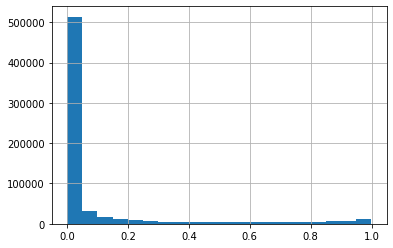

In [28]:
target_df["pred"] = oof_pred
display(target_df["pred"].hist(bins=20))

In [29]:
train = pd.read_csv(CFG["TRAIN_LABEL_CSV"])
if CFG["DEBUG"]:
    train = train.sample(5000).reset_index(drop=True)

train = pd.merge(train, target_df[["contact_id", "pred"]], on="contact_id", how="left")
train = train.fillna(0)
print(len(train))

def func(x_list):
    score = matthews_corrcoef(train['contact'], train["pred"]>x_list[0])
    return -score
x0 = [0.5]
result = minimize(func, x0,  method="nelder-mead")
opt_threshold = result.x[0]
score = round(matthews_corrcoef(train['contact'], train["pred"]>opt_threshold), 5)
threshold = round(opt_threshold, 5)
print(f"score:{score}, threshold:{threshold}")

4721618
score:0.72736, threshold:0.3375


## post proc

In [30]:
train = pd.read_csv(CFG["TRAIN_LABEL_CSV"])
# train = train[train["game_play"].isin(train_game_play)]
print(len(train))

# scoring post process
print(f"score:{score}, threshold:{threshold}")
output_threshold =threshold
best_score = score
best_threshold = threshold
best_window = 1

for window_size in [3, 5, 7, 9, 11, 13]:
    print(f"window size = {window_size}", end=", ")
    proc_sub = post_proc_roll(train, target_df, window_size)
    def func(x_list):
        score = matthews_corrcoef(proc_sub['contact'], proc_sub["proc_pred"]>x_list[0])
        return -score
    x0 = [0.5]
    result = minimize(func, x0,  method="nelder-mead")
    opt_threshold = result.x[0]
    score = round(matthews_corrcoef(proc_sub['contact'], proc_sub["proc_pred"]>opt_threshold), 5)
    threshold = round(opt_threshold, 5)
    print(f"score:{score}, threshold:{threshold}")
    if score > best_score:
        best_score = score
        best_threshold = threshold
        best_window = window_size
print(f"BEST SCORE => window size:{best_window}, score:{best_score}, threshold:{best_threshold} ")

4721618
score:0.72736, threshold:0.3375
window size = 3, score:0.73786, threshold:0.3251
window size = 5, score:0.74001, threshold:0.31436
window size = 7, score:0.73973, threshold:0.33877
window size = 9, score:0.73724, threshold:0.35078
window size = 11, score:0.73548, threshold:0.34326
window size = 13, score:0.73124, threshold:0.33467
BEST SCORE => window size:5, score:0.74001, threshold:0.31436 


In [31]:
print(len(FEATURE_COLS))
print(FEATURE_COLS)
del train

156
['nfl_player_id_1', 'nfl_player_id_2', 'step', 'x_position_1', 'y_position_1', 'speed_1', 'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1', 'team_1', 'jersey_number_1', 'is_lineman_1', 'x_position_shift-6_1', 'x_position_shift-5_1', 'x_position_shift-4_1', 'x_position_shift-3_1', 'x_position_shift-2_1', 'x_position_shift-1_1', 'x_position_shift0_1', 'x_position_shift1_1', 'x_position_shift2_1', 'x_position_shift3_1', 'x_position_shift4_1', 'x_position_shift5_1', 'y_position_shift-6_1', 'y_position_shift-5_1', 'y_position_shift-4_1', 'y_position_shift-3_1', 'y_position_shift-2_1', 'y_position_shift-1_1', 'y_position_shift0_1', 'y_position_shift1_1', 'y_position_shift2_1', 'y_position_shift3_1', 'y_position_shift4_1', 'y_position_shift5_1', 'x_position_2', 'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2', 'team_2', 'jersey_number_2', 'is_lineman_2', 'x_position_shift-6_2', 'x_position_shift-5_2', 'x_position_shift

In [32]:
CFG["features"] = FEATURE_COLS
CFG["PRED_THR"] = output_threshold
CFG["PROC_PRED_THR"] = best_threshold
CFG["proc_window_size"] = best_window

import yaml

cofig_yaml = os.path.join(CFG["EXP_DIR"], "Config.yaml")
with open(cofig_yaml, "w") as f:
    yaml.dump(CFG, f)